In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the sexes into binary
def sex_converter(sex):
    if sex == 'male':
        return 0
    elif sex == 'female':
        return 1
    
# Convert the embarked port into categories
def embarked_converter(port):
    if port == 'S':
        return 0
    elif port == 'C':
        return 1
    elif port == 'Q':
        return -1
    
def snap(y):
    y[y >= 0.5] = 1
    y[y < 0.5] = 0
    return y

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


342 people survived out of 891 passengers
Which means 549 people died out of 891 passengers


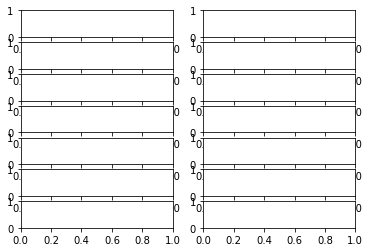

In [2]:
# Load the data from csv & peak @ its contents
train_path = '/kaggle/input/titanic/train.csv'
df_train = pd.read_csv(train_path)

# Convert non-numerics to numerics    
df_train['sex'] = df_train['Sex'].map(sex_converter)    
df_train['port'] = df_train['Embarked'].map(embarked_converter)

# How many people survived ?
total_passengers = len(df_train.index)
total_survived = df_train['Survived'].sum()
total_died = total_passengers - total_survived
print('{} people survived out of {} passengers'.format(total_survived, total_passengers))
print('Which means {} people died out of {} passengers'.format(total_died, total_passengers))

# Is there a relationship between fare & Pclass?
# sns.scatterplot(data=df_train, x='Fare', y='Pclass')
# Only first class tickets > 100

# What's the distribution of survivors for the various metrics
vars_int = ['Sex', 'Pclass', 'Embarked', 'Age', 'Fare', 'Sibsp', 'Parch']
fig, axes = plt.subplots(len(vars_int), 2)


In [3]:


# Need to standardize the data
scaler_age = StandardScaler()
scaler_fare = StandardScaler()
df_train['age'] = scaler_age.fit_transform(df_train[['Age']])
df_train['fare'] = scaler_fare.fit_transform(df_train[['Fare']])

# Only consider Pclass, sex, age, sibsp, fare, parch, & port
# vars_list = ['Pclass', 'sex', 'age', 'SibSp', 'Parch', 'fare', 'port']
vars_list = ['Pclass', 'sex', 'age']
inputs_train = df_train[vars_list].to_numpy()

# Impute nans to mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
inputs_train = imp.fit_transform(inputs_train)

# Convert to tensors for use with keras NN
X_train = tf.constant(inputs_train, dtype=float)
y_true = tf.constant(df_train['Survived'].to_numpy(), dtype=float)

In [4]:
# Construct a neural network model
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
# Now fit the training data
model.fit(X_train, y_true, epochs=100, batch_size=5, verbose=0)

In [6]:
model.evaluate(X_train, y_true)

# Look @ confusion matrix
y_train = model.predict(X_train)
y_train = snap(y_train)
print(confusion_matrix(y_true, y_train))

28/28 [==============================] - 0s 1ms/step - loss: 0.4129 - accuracy: 0.8092
[[476  73]
 [ 97 245]]


In [7]:
# Now load the test data and make predictions
test_path = '/kaggle/input/titanic/test.csv'
df_test = pd.read_csv(test_path)
print(df_test.head())
print(df_test.infto())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


AttributeError: 'DataFrame' object has no attribute 'infto'

In [8]:
df_test['sex'] = df_test['Sex'].map(sex_converter)    
df_test['port'] = df_test['Embarked'].map(embarked_converter)

scaler_age = StandardScaler()
scaler_fare = StandardScaler()
df_test['age'] = scaler_age.fit_transform(df_test[['Age']])
df_test['fare'] = scaler_fare.fit_transform(df_test[['Fare']])

# Only consider Pclass, sex, age, sibsp, fare, parch, & port
inputs_test = df_test[vars_list].to_numpy()

# Impute missing values to mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
inputs_test = imp.fit_transform(inputs_test)

In [9]:
# Convert to tensor and predict
features_test = tf.constant(inputs_test, dtype=float)
labels_test = model.predict(features_test)
labels_test[labels_test >= 0.5] = 1
labels_test[labels_test < 0.5] = 0

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [10]:
# Construct the submission df and save 
df_submit = pd.DataFrame({'PassengerId':df['PassengerId'], 'Survived':labels_test.reshape(-1)})
df_submit['Survived'] = df_submit['Survived'].astype(int)
print(df_submit.head())

df_submit.to_csv('neural_submission.csv', index=False)

NameError: name 'df' is not defined